In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models

# You'll need to install albumentations!
import albumentations as A
from albumentations.pytorch import ToTensorV2

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from PIL import Image, ImageOps
import copy
import pandas as pd

# from datasets import load_dataset
from Datasets import CUB200      # custom class
from Trainer import ModelTrainer # custom class

In [2]:
# The size of our mini batches
batch_size = 64

# How many itterations of our dataset
num_epochs = 5

# Optimizer learning rate
learning_rate = 1e-4

# You'll need to Download Dataset found here
# https://www.kaggle.com/datasets/wenewone/cub2002011
# Unzip and rename to cub_200
# Where to load/save the dataset from 
data_set_root = r"C:\bird data"

# What to resize our images to 
image_size = 128

In [3]:
start_from_checkpoint = False

save_dir = '../data/Models'
model_name = 'ResNet34_CUB'

In [4]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [5]:
train_transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                             A.RandomCrop(height=image_size, width=image_size),
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                             A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                             A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                             A.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                            ToTensorV2()], 
                            bbox_params=A.BboxParams(format='coco',
                                                     min_area=0, min_visibility=0.0, 
                                                     label_fields=['class_labels']))

transform = A.Compose([A.SmallestMaxSize(max_size=image_size),
                       A.RandomCrop(height=image_size, width=image_size),
                       A.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
                       ToTensorV2()], 
                      bbox_params=A.BboxParams(format='coco',
                                               min_area=0, min_visibility=0.0, 
                                               label_fields=['class_labels']))

c:\Users\eblac\anaconda3\envs\torchCPUenv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Intersection over Union (IoU)
To train our model to correctly predict the bounding box we're going to use logistic regression. However to calulate the performance of our model (and the accuracy of the predicted bounding boxes) we're going to use the [Intersection over Union](https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef) metric.

In [6]:
# nn.Module class that will return the IoU for a batch of outputs
class BboxIOU(nn.Module):
    
    def xyhw_to_xyxy(self, bbox):
        """
        Converts from (x_min, y_min, width, height) to (x_min, y_min, x_max, y_max) format
        """
        new_bbox = torch.cat((bbox[:, 0:1], 
                              bbox[:, 1:2],
                              bbox[:, 2:3] + bbox[:, 0:1], 
                              bbox[:, 3:4] + bbox[:, 1:2]), 1)
        return new_bbox

    def bb_intersection_over_union(self, pred_xyhw, target_xyhw):
        pred_xyxy = self.xyhw_to_xyxy(pred_xyhw)
        target_xyxy = self.xyhw_to_xyxy(target_xyhw)

        # Determine the (x, y)-coordinates of the intersection rectangle
        xA = torch.cat((pred_xyxy[:, 0:1], target_xyxy[:, 0:1]), 1).max(dim=1)[0].unsqueeze(1)
        yA = torch.cat((pred_xyxy[:, 1:2], target_xyxy[:, 1:2]), 1).max(dim=1)[0].unsqueeze(1)
        xB = torch.cat((pred_xyxy[:, 2:3], target_xyxy[:, 2:3]), 1).min(dim=1)[0].unsqueeze(1)
        yB = torch.cat((pred_xyxy[:, 3:4], target_xyxy[:, 3:4]), 1).min(dim=1)[0].unsqueeze(1)

        # Compute the area of intersection rectangle
        x_len = F.relu(xB - xA)
        y_len = F.relu(yB - yA)
        # Negative area means no overlap
        interArea = x_len * y_len

        # If you don't have xyhw values, calculate areas like this
#         w1 = (pred_xyxy[:, 0:1] - pred_xyxy[:, 2:3]).abs()
#         h1 = (pred_xyxy[:, 1:2] - pred_xyxy[:, 3:4]).abs()

#         w2 = (target_xyxy[:, 0:1] - target_xyxy[:, 2:3]).abs()
#         h2 = (target_xyxy[:, 1:2] - target_xyxy[:, 3:4]).abs()

#         area1 = w1 * h1
#         area2 = w2 * h2

        area1 = pred_xyhw[:, 2:3] * pred_xyhw[:, 3:4]
        area2 = target_xyhw[:, 2:3] * target_xyhw[:, 3:4]

        # Compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / (area1 + area2 - interArea + 1e-5)

        # Return the intersection over union value
        return iou

    def forward(self, predictions, data):
        """
        data: list of data, index 0 is the input image index [0] is the target
        predictions: raw output of the model, the first 4 outputs are assumed to be the bounding box values
        """
        
        pred_bbox = torch.sigmoid(predictions[:, :4])
        target_bbox = data[1].to(pred_bbox.device)
        
        return self.bb_intersection_over_union(pred_bbox, target_bbox)

# Create the training, testing and validation data 

In [7]:
# Define our Datasets
# You'll need to download the dataset from Kaggle
# https://www.kaggle.com/datasets/wenewone/cub2002011
# Unzip it (and the directories it contains) into the datasets directory 
# and rename the top-level directory cub_200

train_data = CUB200(data_set_root, image_size=image_size, 
                    transform=train_transform, test_train=0)

test_data = CUB200(data_set_root, image_size=image_size, 
                   transform=transform, test_train=1)

# Split trainging data into train and validation set with 90/10% traning/validation split
validation_split = 0.9

n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# Create the Pretrained Network

In [8]:
# Create an instance of the ResNet34 Model
# res_net = models.resnet34(pretrained=True)
# or
res_net = models.resnet34(weights="IMAGENET1K_V1")

In [9]:
model_trainer = ModelTrainer(model=res_net.to(device), output_size=4, device=device, 
                             loss_fun=nn.BCEWithLogitsLoss(), batch_size=batch_size, 
                             learning_rate=learning_rate, save_dir=save_dir, model_name=model_name,
                             eval_metric=BboxIOU(), start_from_checkpoint=start_from_checkpoint)

Starting from scratch


c:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\Trainer.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
c:\Users\eblac\anaconda3\envs\torchCPUenv\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [10]:
model_trainer.set_data(train_set=train_data, test_set=test_data, val_set=valid_data)

Number of training examples: 7376
Number of validation examples: 820
Number of testing examples: 3592


# Set a Learning Rate Scheduler
We can dynamically change the <a href="https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate">learning rate</a> during training to help our model converge to a better minimum!

In [11]:
model_trainer.set_lr_schedule(optim.lr_scheduler.StepLR(model_trainer.optimizer, 
                                                        step_size=1, 
                                                        gamma=0.95))

# View Data

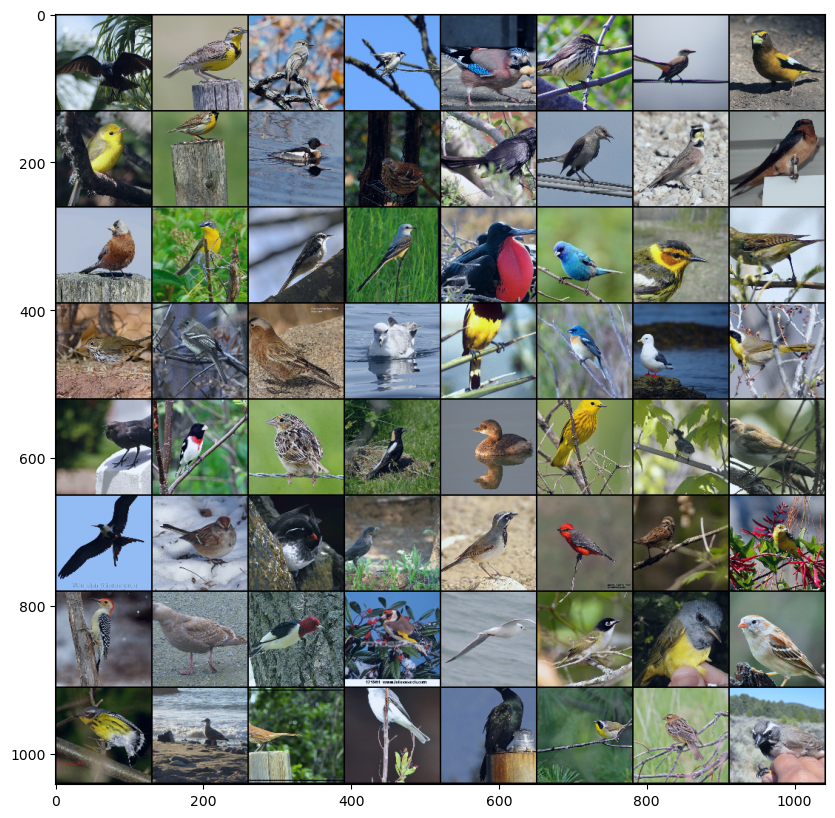

In [12]:
plt.figure(figsize = (20,10))
images, bbox, labels = next(iter(model_trainer.test_loader))
out = torchvision.utils.make_grid(images, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [13]:
example_indx = 3
ex_img = images[example_indx]

# The bounding box is represented in the (x_min, y_min, width, height) format
# aka the coordinate of the top left corner of the box and the box height and width

# draw_bounding_boxes expects it in the (x_min, y_min, x_max, y_max) formatweights=ResNet18_Weights.IMAGENET1K_V1
# aka the coordinates of the top left and bottom right corners of the box
ex_label = bbox[example_indx].unsqueeze(0) * image_size
ex_label[:, 2] += ex_label[:, 0]
ex_label[:, 3] += ex_label[:, 1]

img_out = (((ex_img - ex_img.min())/(ex_img.max() - ex_img.min())) * 255).to(torch.uint8)
img_box = torchvision.utils.draw_bounding_boxes(img_out, ex_label, colors=(0, 255, 0))

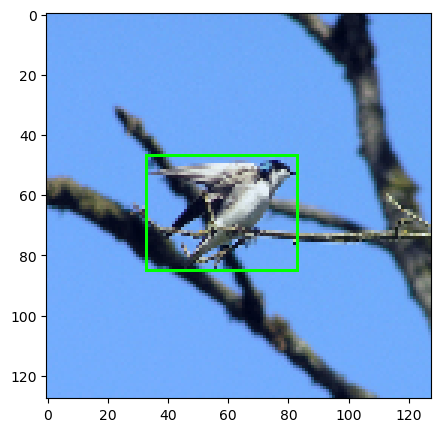

In [14]:
plt.figure(figsize = (5,5))
out = torchvision.utils.make_grid(img_box.unsqueeze(0).float(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [15]:
# Lets see how many Parameter's our Model has!
num_params = 0
for param in model_trainer.model.parameters():
    num_params += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (num_params, num_params//1e6))

This model has 21286724 (approximately 21 Million) Parameters!


# Train Model!
Our full training method is now fully contained within the trainner class! Simply run the run_training method and specify how many epochs it should train for!

In [16]:
model_trainer.run_training(num_epochs=num_epochs)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

c:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\Trainer.py:177: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\eblac\anaconda3\envs\torchCPUenv\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

c:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\Trainer.py:221: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/116 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/13 [00:00<?, ?it/s]

# View Results

In [17]:
print("The highest validation IoU was %.2f" %(model_trainer.best_valid_acc))

The highest validation IoU was 0.80


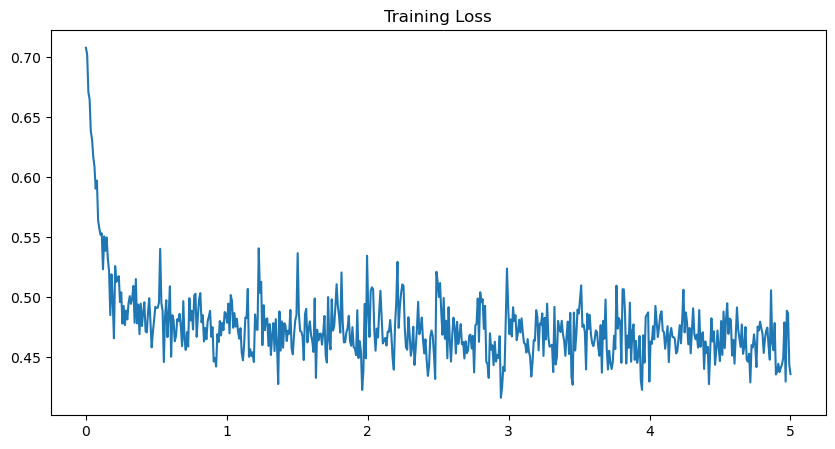

In [18]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_loss_logger))
_ = plt.plot(train_x, model_trainer.train_loss_logger)
_ = plt.title("Training Loss")

## Model Prediction!

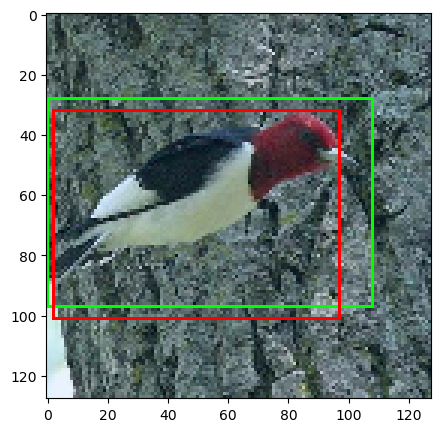

In [20]:
# Select an image to test
example_indx = 50
ex_img = images[example_indx]
img_out = (((ex_img - ex_img.min())/(ex_img.max() - ex_img.min())) * 255).to(torch.uint8)

real_label = bbox[example_indx].unsqueeze(0) * image_size
real_label[:, 2] += real_label[:, 0]
real_label[:, 3] += real_label[:, 1]

# Get the model's prediction for the Bounding Box
model_trainer.eval()
with torch.no_grad():
    pred_out = torch.sigmoid(model_trainer(ex_img.unsqueeze(0).to(device)))
    pred_label = (pred_out * image_size).cpu()
    pred_label[:, 2] += pred_label[:, 0]
    pred_label[:, 3] += pred_label[:, 1]
    
# Draw the box on the image
img_box = torchvision.utils.draw_bounding_boxes(img_out, real_label, colors=(0, 255, 0))
img_box = torchvision.utils.draw_bounding_boxes(img_box, pred_label, colors=(255, 0, 0))

plt.figure(figsize = (5,5))
out = torchvision.utils.make_grid(img_box.unsqueeze(0).float(), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

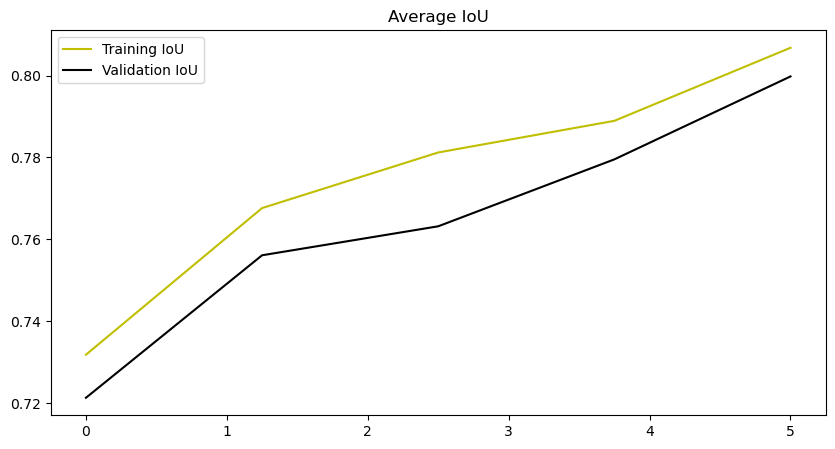

In [21]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_acc_logger))
_ = plt.plot(train_x, model_trainer.train_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model_trainer.val_acc_logger))
_ = plt.plot(valid_x, model_trainer.val_acc_logger, c = "k")

_ = plt.title("Average IoU")
_ = plt.legend(["Training IoU", "Validation IoU"])

# Evaluate

In [22]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = model_trainer.evaluate_model(train_test_val="test")
print("The Test Average IoU is: %.2f" %(test_acc))

Evaluating Test Set:   0%|          | 0/57 [00:00<?, ?it/s]

The Test Average IoU is: 0.79
